<a href="https://colab.research.google.com/github/Anyaoma/My-projects/blob/main/Bates_Call_price_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin
from scipy.optimize import minimize
from numpy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.DataFrame({
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5, 227.5, 230.0, 232.5, 235.0, 237.5],
    'T': [60 / 250] * 10,  # Time to maturity (15 days, assuming 250 trading days per year),
    'Price': [16.78, 17.65, 16.86, 16.05, 15.10, 11.03, 12.15, 13.37, 14.75, 15.62],  # Call prices,
    'Type': ['C','C','C','C','C','P','P','P','P','P'],
    'r':[0.015]*10,

})

In [ ]:
kappa_v=1.5230191197217156
theta_v=0.022459667104422654
sigma_v=1.208676707716792
rho=-1.0
v0=0.10452953869850334

## Bates Characteristic Function

$$
\
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

In [ ]:
def Heston_char_func(u, T, r, kappa, theta, sigma, rho, v0):
    c1 = kappa * theta

    c2 = -np.sqrt((rho * sigma * u * 1j - kappa) ** 2 - sigma ** 2 * (-u ** 2 - 1j * u))

    c3 = (kappa - rho * sigma * u * 1j + c2) / (kappa - rho * sigma * u * 1j - c2)

    H1 = r * 1j * u * T + (c1 / sigma ** 2) * ((kappa - rho * sigma * u * 1j + c2) * T - 2 * np.log((1 - c3*np.exp(c2 * T)) / (1 - c3)))

    H2 = ((kappa - rho * sigma * u * 1j + c2) / sigma**2) * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))

    return np.exp(H1 + H2 * v0)


def Merton_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))* T)

    return char_func_value


def Bates_char_func(u, T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = Heston_char_func(u, T, r, kappa, theta, sigma, rho, v0)
    M76J = Merton_char_func(u, T, lamb, mu, delta)
    return H93 * M76J


def Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K):
    char_f = Bates_char_func(u - 1j * 0.5, T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta)
    int_value = 1/(u**2 + 0.25) * (np.exp(1j * u * np.log(S0/K)) * char_f).real
    return int_value

def Bates_call_value(T, r, kappa, theta, sigma, rho, lamb, mu, v0, delta, S0, K):
    int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]

    call_value =  max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)

    return call_value


i= 0
min_MSE = 5000

def Bates_error_function(p0):
    ''' error function to be minimized
    '''
    global min_MSE, i, local_opt,opt1
    # Initial parameters for kappa_v, theta_v, sigma_v, rho, v0

    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    mse = []

    for _, option in data.iterrows():
        if option['Type'] == 'C':
           model_price = Bates_call_value( option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
           mse.append((model_price - option['Price'])**2)
        else:
            call_price = Bates_call_value(option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
            present_value_strike = option['Strike'] * np.exp(-option['r']*option['T'])
            model_price = call_price  - 232.90 + present_value_strike
            mse.append((model_price - option['Price'])**2)

    mean_mse = np.mean(mse)

    if mean_mse < min_MSE:
        min_MSE = mean_mse
        opt1 = p0
    min_ = min(min_MSE, mean_mse)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (mean_mse, min_))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return mean_mse + penalty
    return mean_mse



def calibration_short_merton():
    ''' calibration function
    '''
       # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        Bates_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        Bates_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=2000,
        maxfun=2000,
    )
    return opt2



def full_model_calibration(p0):
    '''full model calibration
    '''
    model_values = []
    kappa, theta, sigma, rho, v0,lamb, mu, delta = p0
    global min_MSE, i, local_opt

    for _, option in data.iterrows():
        if option['Type'] == 'C':
           model_price = Bates_call_value( option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
           model_values.append(model_price)
        else:
            call_price = Bates_call_value( option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
            present_value_strike = option['Strike'] * np.exp(-option['r']*option['T'])
            model_price = call_price  - 232.90 + present_value_strike
            model_values.append(model_price)

    data['Model Price'] = model_values
    return data


def full_error_funct2(p0):
    '''full model calibration
    '''
    ms_ = []
    kappa, theta, sigma, rho, v0,lamb, mu, delta = p0
    global min_MSE, i, local_opt,opt1

    for _, option in data.iterrows():
        if option['Type'] == 'C':
           model_price = Bates_call_value( option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
           ms_.append((model_price - option['Price'])**2)
        else:
            call_price = Bates_call_value(option['T'], option['r'], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, 232.90, option['Strike'])
            present_value_strike = option['Strike'] * np.exp(-option['r']*option['T'])
            model_price = call_price  - 232.90 + present_value_strike
            ms_.append((model_price - option['Price'])**2)

    mean_mse = np.mean(ms_)

    if mean_mse < min_MSE:
        min_MSE = mean_mse
        opt1 = p0
    min_ = min(min_MSE, mean_mse)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (mean_mse, min_))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return mean_mse + penalty
    return mean_mse

def Bates_short_optimize(opt):
    ''' error function to be minimized
    '''
    opt2 = fmin(
        full_error_funct2,
        opt,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=2000,
        maxfun=2000,
    )
    return opt2


## Calibrated Heston model parameters

## lewis (2001) approach to call pricing under heston

In [ ]:
i= 0
min_MSE = 5000
local_opt = True

In [ ]:

opt1 = [ 0.4, -0.5,  0.5]

<ipython-input-37-32f0be960d5a>:41: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]
<ipython-input-37-32f0be960d5a>:12: RuntimeWarning: overflow encountered in exp
  return np.exp(H1 + H2 * v0)
<ipython-input-37-32f0be960d5a>:32: RuntimeWarning: invalid value encountered in scalar multiply
  return H93 * M76J
<ipython-input-37-32f0be960d5a>:41: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]


   0 | [ 0.  -0.5  0. ] | 18795.187 | 5000.000


<ipython-input-37-32f0be960d5a>:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]
<ipython-input-37-32f0be960d5a>:65: RuntimeWarning: overflow encountered in scalar power
  mse.append((model_price - option['Price'])**2)
<ipython-input-37-32f0be960d5a>:70: RuntimeWarning: overflow encountered in scalar power
  mse.append((model_price - option['Price'])**2)


  25 | [ 0.2  -0.5   0.25] |     inf | 186.877
  50 | [ 0.4 -0.5  0.5] | 37978.885 | 165.881
  75 | [ 0.2   -0.2    0.525] | 28495.695 | 165.881
 100 | [ 0.2      -0.200625  0.5     ] | 1314.497 | 165.881
 125 | [ 0.20004747 -0.19999105  0.49998033] | 163.230 | 163.230
 150 | [ 0.20004252 -0.19999101  0.5000066 ] | 163.336 | 163.106
 175 | [ 0.20004668 -0.19999037  0.49999413] | 195.726 | 163.099
 200 | [ 0.20004443 -0.19999024  0.50000635] | 163.097 | 163.096
 225 | [ 0.19998337 -0.19998533  0.5003582 ] | 163.070 | 163.070
 250 | [ 0.19940062 -0.19993848  0.50371608] | 162.924 | 162.916
 275 | [ 0.19923659 -0.1999253   0.5046612 ] | 162.916 | 162.916
 300 | [ 0.1988791  -0.19989643  0.50671949] | 162.890 | 162.890
 325 | [ 0.1987568  -0.19988583  0.50741631] | 162.597 | 162.464
 350 | [ 0.19550471 -0.19961424  0.52604762] | 161.932 | 161.544
 375 | [ 0.19496959 -0.19956566  0.52907284] | 193.238 | 160.850
 400 | [ 0.19295941 -0.199389    0.54049769] | 159.994 | 159.994
 425 | [ 0.1919

In [ ]:
params

array([ 0.17904036, -0.19803027,  0.61818574])

In [ ]:
kappa_v=1.5230191197217156
theta_v=0.022459667104422654
sigma_v=1.208676707716792
rho=-1.0
v0=0.10452953869850334
lamb, mu, delta = params


In [ ]:
all_params = [1.5230191197217156, 0.022459667104422654,1.208676707716792,-1.0, 0.10452953869850334, 0.17904036,-0.19803027,0.61818574 ]

In [ ]:
new_params = Bates_short_optimize(all_params)

<ipython-input-53-d9237fb9ffce>:41: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]


   0 | [ 1.52301912  0.02245967  1.20867671 -1.          0.10452954  0.17904036
 -0.19803027  0.61818574] | 155.823 | 155.823


<ipython-input-53-d9237fb9ffce>:12: RuntimeWarning: overflow encountered in exp
  return np.exp(H1 + H2 * v0)
<ipython-input-53-d9237fb9ffce>:32: RuntimeWarning: invalid value encountered in scalar multiply
  return H93 * M76J
<ipython-input-53-d9237fb9ffce>:41: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]
<ipython-input-53-d9237fb9ffce>:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)

  25 | [ 1.57061347  0.02260004  1.21623094 -1.00625     0.10518285  0.18015936
 -0.19307951  0.6220494 ] | 17339543139011574598722205496201800850261500607751564579871090705044602880.000 | 135.585


<ipython-input-53-d9237fb9ffce>:41: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]


  50 | [ 1.54832375  0.02278314  1.2262846  -1.00344579  0.10572259  0.17962525
 -0.19078267  0.62633441] | 345.103 | 133.751
  75 | [ 1.53690369  0.02271672  1.22895231 -1.00118209  0.10587997  0.17978125
 -0.19200742  0.62471239] | 151.275 |  94.397
 100 | [ 1.54004009  0.02272375  1.22449883 -1.00199939  0.10579711  0.17969173
 -0.19214465  0.62651016] | 196.444 |  94.397
 125 | [ 1.54100887  0.02272807  1.22317381 -1.00223389  0.10577855  0.17964232
 -0.19217053  0.62701755] | 161.799 |  94.397
 150 | [ 1.541077    0.02272595  1.2231293  -1.00225787  0.10577312  0.17963196
 -0.19217984  0.62711998] | 374467888932822777331712.000 |  53.970
 175 | [ 1.54104502  0.02272596  1.22311881 -1.00224574  0.10577504  0.17963426
 -0.19217907  0.62712337] | 152.814 |  53.970
 200 | [ 1.54102583  0.0227258   1.22314146 -1.00224382  0.10577523  0.17963365
 -0.19217951  0.62712572] | 4700881028091162892469165133231839962346862933745155219855874660559597815028277672306591381906374374331094532423150

<ipython-input-53-d9237fb9ffce>:173: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt2 = fmin(


In [ ]:
new_params

array([ 1.54103369,  0.02272603,  1.22313666, -1.00224492,  0.10577522,
        0.1796318 , -0.19217915,  0.62712566])

In [ ]:
dataset = full_model_calibration(new_params)

<ipython-input-53-d9237fb9ffce>:12: RuntimeWarning: overflow encountered in exp
  return np.exp(H1 + H2 * v0)
<ipython-input-53-d9237fb9ffce>:32: RuntimeWarning: invalid value encountered in scalar multiply
  return H93 * M76J
<ipython-input-53-d9237fb9ffce>:41: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: Bates_integral_value(u,T, r, kappa, theta, sigma, rho, v0, lamb, mu, delta, S0, K ),0,np.inf, limit=500)[0]


In [ ]:
dataset

,Strike,T,Price,Type,r,Model Price
0,227.5,0.24,16.78,C,0.015,12.979447
1,230.0,0.24,17.65,C,0.015,12.333854
2,232.5,0.24,16.86,C,0.015,12.650616
3,235.0,0.24,16.05,C,0.015,13.061860
4,237.5,0.24,15.10,C,0.015,0.000000
5,227.5,0.24,11.03,P,0.015,6.761919
6,230.0,0.24,12.15,P,0.015,8.607342
7,232.5,0.24,13.37,P,0.015,11.415121
8,235.0,0.24,14.75,P,0.015,14.317381
9,237.5,0.24,15.62,P,0.015,3.746537


Optimized Heston Parameters: kappa_v=1.5410336853772266, theta_v=0.022726028846236555, sigma_v=1.223136660770995, rho=-1.0022449248532264, v0=0.10577522016123563


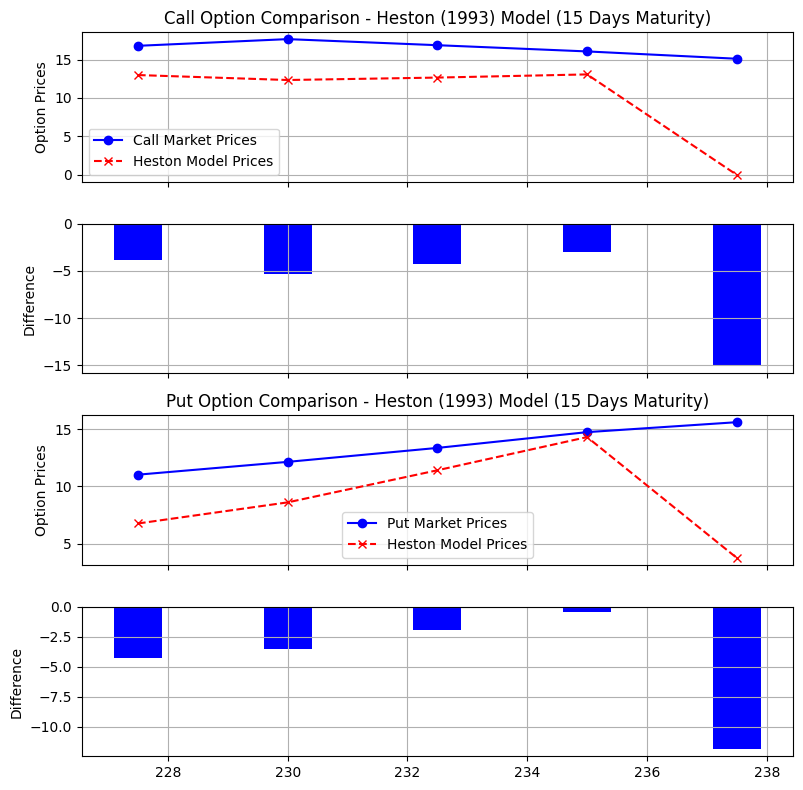

In [ ]:
# Calculate differences and percentage differences
dataset['Difference'] = dataset['Model Price'] - dataset['Price']
dataset['Percentage Difference'] = (dataset['Difference'] / dataset['Price']) * 100

kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta= new_params
print(f"Optimized Heston Parameters: kappa_v={kappa_v}, theta_v={theta_v}, sigma_v={sigma_v}, rho={rho}, v0={v0}")

# Plot Market vs Model Prices
fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

call_options = dataset[dataset['Type'] == 'C']
put_options = dataset[dataset['Type'] == 'P']

# Plot 1: Market vs Model Prices
axs[0].plot(call_options['Strike'], call_options['Price'], label='Call Market Prices', marker='o', color='blue')
axs[0].plot(call_options['Strike'], call_options['Model Price'], label='Heston Model Prices', marker='x', color='red', linestyle='--')
axs[0].set_ylabel("Option Prices")
axs[0].set_title("Call Option Comparison - Heston (1993) Model (15 Days Maturity)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Difference between Market and Model Prices
axs[1].bar(call_options['Strike'], call_options['Difference'], color='blue')
axs[1].set_ylabel("Difference")
axs[1].grid(True)

# Plot 1: Market vs Model Prices
axs[2].plot(put_options['Strike'], put_options['Price'], label='Put Market Prices', marker='o', color='blue')
axs[2].plot(put_options['Strike'], put_options['Model Price'], label='Heston Model Prices', marker='x', color='red', linestyle='--')
axs[2].set_ylabel("Option Prices")
axs[2].set_title("Put Option Comparison - Heston (1993) Model (15 Days Maturity)")
axs[2].legend()
axs[2].grid(True)

# Plot 2: Difference between Market and Model Prices
axs[3].bar(put_options['Strike'], put_options['Difference'], color='blue')
axs[3].set_ylabel("Difference")
axs[3].grid(True)

plt.tight_layout()
plt.show()